### Práctica MLOps con MLflow

#### Imports necesarios

In [1]:
import mlflow
from mlflow.tracking import MlflowClient

import numpy as np
import matplotlib.pyplot as plt

#### Carga de datos y preparación

In [2]:
import kagglehub
import os

path = kagglehub.dataset_download("imsparsh/flowers-dataset")
print(path)

c:\Users\Ghino\Desktop\mlflow_practica\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\Ghino\.cache\kagglehub\datasets\imsparsh\flowers-dataset\versions\2


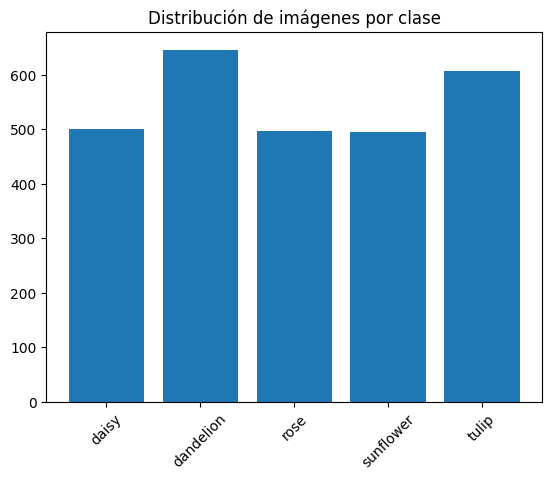

In [3]:
# Visualizar ejemplos
import matplotlib.pyplot as plt

classes = os.listdir(os.path.join(path, "train"))
counts = {}

for cls in classes:
    counts[cls] = len(os.listdir(os.path.join(path, "train", cls)))

plt.bar(counts.keys(), counts.values())
plt.title("Distribución de imágenes por clase")
plt.xticks(rotation=45)
plt.show()


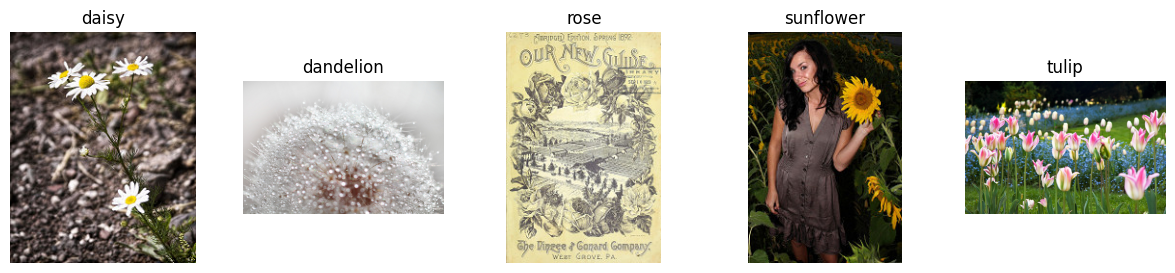

In [4]:
from tensorflow.keras.preprocessing.image import load_img
import random

fig, axes = plt.subplots(1, 5, figsize=(15,3))

for ax, cls in zip(axes, classes):
    img_path = random.choice(os.listdir(os.path.join(path, "train", cls)))
    img = load_img(os.path.join(path, "train", cls, img_path))
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")

plt.show()


#### Parametros para el entrenamiento 

In [11]:
params = {
    "input_shape": (224, 224, 3),
    "batch_size": 36,
    "epochs": 20,
    "learning_rate": 0.0001,
    "optimizer": "adam",
    "base_model": "MobileNetV2",
    "trainable_base": False
}

#### Data augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# generadores
train_gen = train_datagen.flow_from_directory(
    os.path.join(path, "train"),
    target_size=params["input_shape"][:2],
    batch_size=params["batch_size"],
    class_mode="categorical",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    os.path.join(path, "train"),
    target_size=params["input_shape"][:2],
    batch_size=params["batch_size"],
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.


In [ ]:
# Visualizar aumento
def visualize_augmentation(generator, num_examples=5, augmentations_per_image=8):

    generator.reset()
    images, labels = next(generator)
    
    images = images[:num_examples]
    labels = labels[:num_examples]
    
    class_names = list(generator.class_indices.keys())
    
    # Crear figura
    fig, axes = plt.subplots(
        num_examples, 
        augmentations_per_image + 1,  # +1 para la imagen original
        figsize=(20, 4 * num_examples)
    )
    
    if num_examples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_examples):
        # Obtener clase de la imagen
        class_idx = np.argmax(labels[i])
        class_name = class_names[class_idx]
        
        # Columna 0: Imagen original
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title(f"Original\n{class_name}", fontsize=12, fontweight='bold')
        axes[i, 0].axis('off')
        axes[i, 0].set_facecolor('#e6f3ff')
        
        img_array = images[i:i+1]  
        
        # Crear generador de augmentation para esta imagen
        temp_gen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode="nearest"
        )
        
        # Generar versiones aumentadas
        aug_iter = temp_gen.flow(
            img_array,
            batch_size=1,
            shuffle=False
        )
        
        for j in range(augmentations_per_image):
            aug_img = next(aug_iter)[0]
            axes[i, j + 1].imshow(aug_img)
            axes[i, j + 1].set_title(f"Augmented {j+1}", fontsize=10)
            axes[i, j + 1].axis('off')
    
    plt.tight_layout()
    plt.suptitle(
        'Original vs Transformaciones',
        fontsize=16,
        fontweight='bold',
        y=1.002
    )
    plt.show()

visualize_augmentation(train_gen, num_examples=3, augmentations_per_image=5)

##### Relanzar esta sección para usar data sin aumento

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_no_aug = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen_no_aug = datagen_no_aug.flow_from_directory(
    os.path.join(path, "test"),
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_gen_no_aug = datagen_no_aug.flow_from_directory(
    os.path.join(path, "train"),
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 0 images belonging to 0 classes.
Found 548 images belonging to 5 classes.


#### Preparación del modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
# lanzar despues de cambios en parametros / generadores 

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=params["input_shape"]
)

base_model.trainable = params["trainable_base"]

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(train_gen.num_classes, activation="softmax")(x) # train_gen_no_aug si se usa sin aumento
                                                                      # train_gen si se usa con aumento

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=params["learning_rate"]),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

#### Logging en MLFlow

In [ ]:
import mlflow
import mlflow.tensorflow
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

mlflow.set_experiment("Flower_Classification_MNet2_NoAugm")

In [ ]:
# relanzar para nuevas runs

with mlflow.start_run(run_name=f"MobileNet_run1_no_augm"):

    mlflow.log_params(params)

    history = model.fit(
        train_gen, #train_gen_no_aug si se usa sin aumento | train_gen si se usa con aumento
        validation_data=val_gen, #val_gen_no_aug si se usa sin aumento | val_gen si se usa con aumento
        epochs=params["epochs"]
    )

    
    for epoch in range(len(history.history["loss"])):
        mlflow.log_metric("train_loss", history.history["loss"][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history["val_loss"][epoch], step=epoch)
        mlflow.log_metric("train_accuracy", history.history["accuracy"][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history["val_accuracy"][epoch], step=epoch)

    mlflow.tensorflow.log_model(
        model,
        name="model",
        registered_model_name="FlowerClassifierCNNv3"
    )

    mlflow.log_artifacts(
        local_dir=os.path.join(path, "train"),
        artifact_path="dataset/train"
    )


#### Pase a STG y PROD

In [32]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

In [ ]:
client.transition_model_version_stage(
    name="FlowerClassifierCNNv3",
    version=10,  # versión ganadora
    stage="Staging"
)

In [ ]:
client.transition_model_version_stage(
    name="FlowerClassifierCNNv3",
    version=10,
    stage="Production"
)

#### Consumo del modelo

In [33]:
model_uri = "models:/FlowerClassifierCNNv3/Production"
prod_model = mlflow.pyfunc.load_model(model_uri)

In [51]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

img = load_img(
    os.path.join(path, "test", os.listdir(os.path.join(path, "test"))[23]),
    target_size=params["input_shape"][:2]
)

img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = prod_model.predict(img_array)
print("Predicción:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicción: [[0.64637417 0.01065762 0.21639867 0.0271666  0.09940296]]


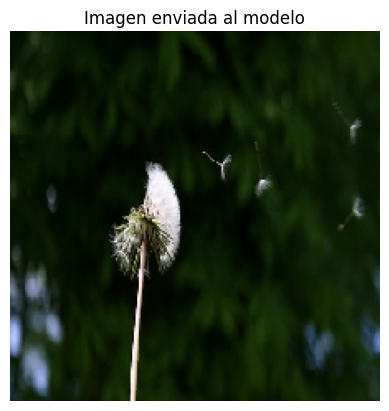

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Flor predicha: dandelion
Confianza: 98.29%

Probabilidades por clase:
- daisy: 1.59%
- dandelion: 98.29%
- rose: 0.02%
- sunflower: 0.08%
- tulip: 0.02%


In [53]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

classes = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

# cargar imagen desde /test
img_path = os.path.join(path, "test", os.listdir(os.path.join(path, "test"))[17])

img = load_img(
    img_path,
    target_size=params["input_shape"][:2]
)

# mostrar imagen
plt.imshow(img)
plt.axis("off")
plt.title("Imagen enviada al modelo")
plt.show()

# preparar imagen
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# predicción
pred = prod_model.predict(img_array)[0]

pred_idx = int(np.argmax(pred))
pred_class = classes[pred_idx]
confidence = float(pred[pred_idx]) * 100

print(f"Flor predicha: {pred_class}")
print(f"Confianza: {confidence:.2f}%")

print("\nProbabilidades por clase:")
for i, prob in enumerate(pred):
    print(f"- {classes[i]}: {prob*100:.2f}%")
